In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import regnet_y_400mf
from torchvision.transforms import v2

from src.save_model import save_model
from src.train_model import train_one_epoch

In [3]:
torch.cuda.empty_cache()

### 1. Загрузка и предобразботка данных

In [4]:
train_transforms = v2.Compose([
    # v2.RandomRotation([-5, 5], fill=255),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomPhotometricDistort(contrast=[0.9, 1.1],
                                hue=[-0.05, 0.05]),
                                v2.Resize((224, 224)),
                                v2.ToTensor(),
                                # v2.Normalize([0.5], [0.5])
                                ])
val_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    # v2.Normalize([0.5], [0.5])
    ])

/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
train_dataset = ImageFolder('ogyeiv2/train', transform=train_transforms)
val_dataset = ImageFolder('ogyeiv2/test', transform=val_transforms)

In [6]:
classes = train_dataset.classes

algoflex_forte_dolo_400_mg
algoflex_forte_dolo_400_mg
algoflex_forte_dolo_400_mg
algoflex_forte_dolo_400_mg
algoflex_forte_dolo_400_mg


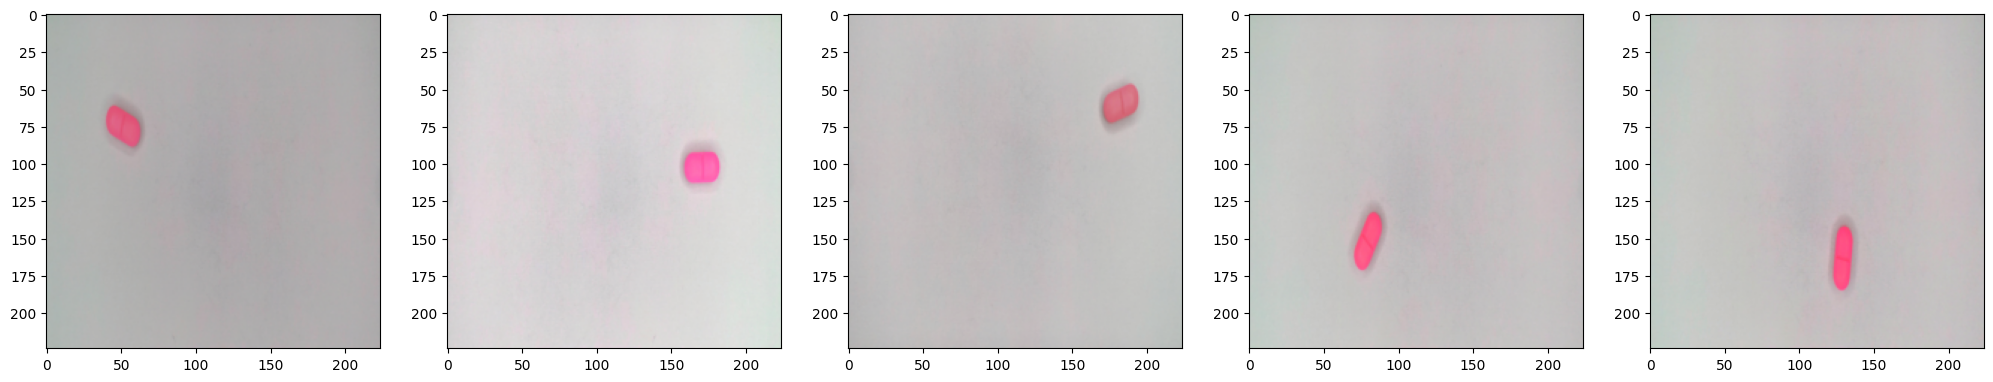

In [7]:
fig = plt.figure(figsize=(25, 5))
for i in range(1, 6):
    image, label = train_dataset[100 + i]
    plt.subplot(1, 5, i)
    plt.imshow(image.permute((1, 2, 0)))
    print(classes[label])
plt.show()


In [8]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)

In [9]:
print('Количество классов:', len(classes))
print('Количество изображений в обучающем датасете:', len(train_dataset))
print('Количество изображений в валидационном датасете:', len(val_dataset))

Количество классов: 84
Количество изображений в обучающем датасете: 2352
Количество изображений в валидационном датасете: 504


### 2. Объявление модели

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Устройство обучения:', device)

Устройство обучения: cuda


##### Дообучение модели

In [11]:
model = regnet_y_400mf(weights='IMAGENET1K_V2')

In [12]:
model.fc = nn.Linear(in_features=440, out_features=84)

In [13]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True

##### Собственный классификатор

In [14]:
# class TabletClassifier(nn.Module):
#     def __init__(self, ):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 256, 3, padding='same')
#         self.pool = nn.MaxPool2d(2)
#         self.bn1 = nn.BatchNorm2d(256)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(256, 84)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.pool(x)

#         x = self.avgpool(x)
        
#         x = self.flatten(x)
#         x = self.fc(x)
#         return x

In [15]:
# model = TabletClassifier()

In [16]:
model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

### 3. Обучение или дообучение

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
EPOCHS = 50

In [ ]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = train_one_epoch(train_loader=train_loader, model=model,
                                 criterion=criterion, optimizer=optimizer,
                                 device=device, epoch_index=epoch)
    print(f'Epoch: {epoch}, train loss: {train_loss}')
    train_losses.append(train_loss)
    
    running_vloss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_vloss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = running_vloss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch: {epoch}, val loss: {val_loss}, val accuracy: {val_accuracy}')
    val_losses.append(val_loss)

    save_model(model.state_dict(), f'meds_classifier_{epoch}.pt')

    print('-' * 50)

Эпоха: 0, номер батча: 19, ошибка: 4.500340127944947
Epoch: 0, train loss: 4.500340127944947
Epoch: 0, val loss: 4.371413588523865, val accuracy: 0.02976190476190476
--------------------------------------------------
Эпоха: 1, номер батча: 19, ошибка: 4.237251877784729
Epoch: 1, train loss: 4.237251877784729
Epoch: 1, val loss: 3.9742201566696167, val accuracy: 0.11507936507936507
--------------------------------------------------
Эпоха: 2, номер батча: 19, ошибка: 4.025519227981567
Epoch: 2, train loss: 4.025519227981567
Epoch: 2, val loss: 3.767169624567032, val accuracy: 0.17063492063492064
--------------------------------------------------
Эпоха: 3, номер батча: 19, ошибка: 3.839431273937225
Epoch: 3, train loss: 3.839431273937225
Epoch: 3, val loss: 3.59491503238678, val accuracy: 0.26587301587301587
--------------------------------------------------
Эпоха: 4, номер батча: 19, ошибка: 3.719864809513092
Epoch: 4, train loss: 3.719864809513092
Epoch: 4, val loss: 3.406369149684906, 

In [ ]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

### 4. Оценка качества